In [144]:
import torch
import numpy as np

In [9]:
for ds in ['v2', 'sketch', 'rend', 'adv']:
    inv69 = torch.load(f"./logits_files/inv69_eval_on_{ds}.pth")
    tar = torch.load(f"./logits_files/{ds}_targets.pth")
    print(inv69.shape, tar.shape)

torch.Size([10000, 1000]) torch.Size([10000])
torch.Size([50889, 1000]) torch.Size([50889])
torch.Size([30000, 200]) torch.Size([30000])
torch.Size([7500, 200]) torch.Size([7500])


In [145]:
class _ECELoss(torch.nn.Module):

    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, softmaxes, labels):
#         softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=softmaxes.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece
ece_criterion = _ECELoss(n_bins=15).cuda()

In [146]:
import torch.nn.functional as F
import inspect
from netcal.metrics import ECE

cecriterion = torch.nn.CrossEntropyLoss().cuda()
nll_criterion = torch.nn.CrossEntropyLoss().cuda()

def get_metrics(outs, tars, names, printing=True, input_softmax=False, num_classes=1000):
    losses = []
    eces = []
    accs = []
    acc_pcs = []
    for out, tar,name in zip(outs,tars,names):
        ece_netcal = ECE(15)
        
        out = out.cpu()
        tar = tar.cpu()
        correct_per_class = torch.zeros(num_classes).to(tar.device)
        total_per_class = torch.zeros(num_classes).to(tar.device)

        if not input_softmax:
            out = out.softmax(-1)
        ece1 = ece_netcal.measure(out.numpy(), tar.numpy())
        ece2 = ece_criterion(out, tar)
        
        loss = F.nll_loss(torch.log(out), tar)
        _, pred = out.max(-1)
        correct_vec = (pred == tar)
        ind_per_class = (tar.unsqueeze(1) == torch.arange(num_classes).to(tar.device)) # indicator variable for each class
        correct_per_class = (correct_vec.unsqueeze(1) * ind_per_class).sum(0)
        total_per_class = ind_per_class.sum(0)

        acc = (correct_vec.sum()) / len(tar)
        acc_per_class = correct_per_class / total_per_class
        if printing:
            print(name)
            print(f"NLL: {loss.item()} | ECE: {ece1} | ECE: {ece2}")
            print("Acc:", acc.item())
        losses.append(loss.item())
        eces.append(ece1)
        accs.append(acc.item())
        acc_pcs.append(acc_per_class)
    return losses, eces, accs, acc_pcs

def ensem_BEI(all_eq,all_base,all_inv,same_tar,num_E=0, num_B=0, num_I=0, num_comb=5, err='std'):
    ee_nll = []
    ee_ece = []
    ee_acc = []
    ee_auuqc = []
    for i in range(num_comb):
        eq_list = []
        base_list = []
        inv_list = []
        
        eq_choice = np.random.choice(len(all_eq), num_E, replace=False)
        for ind in eq_choice:
            eq_list.append(all_eq[ind])
        
        base_choice = np.random.choice(len(all_base), num_B, replace=False)
        for ind in base_choice:
            base_list.append(all_base[ind])
        
        inv_choice = np.random.choice(len(all_inv), num_I, replace=False)
        for ind in inv_choice:
            inv_list.append(all_inv[ind])
        
        out_list = list(eq_list) + list(base_list) + list(inv_list)
        out_list = [torch.Tensor(x.cpu()) for x in out_list]
        ee_out = torch.stack(out_list).softmax(-1).mean(dim=0).cuda()
        nll, ece, acc, _ = get_metrics([ee_out],[same_tar],[f'EE_comb{i}'], printing=False, input_softmax=True)    
        ee_nll.append(nll)
        ee_ece.append(ece)  
        ee_acc.append(acc)
        x1, acc1, auuqc1 = get_ROC([model1.softmax(-1) for model1 in out_list], same_tar)
        ee_auuqc.append(auuqc1)
        
    print("E"*num_E + "B"*num_B + "I"*num_I)
    if err=='std':
        print(f"NLL: {np.mean(ee_nll):.4f} +/- {np.std(ee_nll):.4f}")
        print(f"ECE: {np.mean(ee_ece):.4f} +/- {np.std(ee_ece):.4f}")
        print(f"Acc: {np.mean(ee_acc):.4f} +/- {np.std(ee_acc):.4f}")
        print(f"AUUQC: {np.mean(ee_auuqc):.6f} +/- {np.std(ee_auuqc):.6f}")
        
    elif err=='var':
        print(f"NLL: {np.mean(ee_nll):.4f} +/- {np.var(ee_nll):.4f}")
        print(f"ECE: {np.mean(ee_ece):.4f} +/- {np.var(ee_ece):.4f}")
        print(f"Acc: {np.mean(ee_acc):.4f} +/- {np.var(ee_acc):.4f}")
        print(f"AUUQC: {np.mean(ee_auuqc):.6f} +/- {np.std(ee_auuqc):.6f}")

        
def get_classwise_IE(acc_rotinv, acc_roteq, num_classes=1000):
    print("use order I, E")
    y = torch.stack([v for v in [acc_rotinv, acc_roteq]], dim=-1)

    fac = num_classes/100
    best_inv_eq = (y[:,0] == y[:,1])
    print(f"all equal best: {(best_inv_eq.sum())/fac:.1f}%")

    i_uniq = (y[:,0] > y[:,1]) 
    e_uniq = (y[:,1] > y[:,0]) 

    # single model uniquely best
    print(f"I uniquely best: {i_uniq.sum()/fac:.1f}%")
    print(f"E uniquely best: {e_uniq.sum()/fac:.1f}%")
    
def get_classwise(acc_base, acc_rotinv, acc_roteq, num_classes=1000):
    print("use order B, I, E")
    y = torch.stack([v for v in [acc_base, acc_rotinv, acc_roteq]], dim=-1)

    fac = num_classes/100
    # all 3 models equally good
    best_base_inv_eq = (y[:,0] == y[:,1]) & (y[:,1] == y[:,2])
    # 2 models equally good and is better
    best_base_inv = (y[:,0] == y[:,1]) & (y[:,0] > y[:,2])
    best_base_eq = (y[:,0] == y[:,2]) & (y[:,0] > y[:,1])
    best_inv_eq = (y[:,1] == y[:,2]) & (y[:,1] > y[:,0])
    # 2 models equally good and is worse
    worse_base_inv = (y[:,0] == y[:,1]) & (y[:,0] < y[:,2]) # best eq
    worse_base_eq = (y[:,0] == y[:,2]) & (y[:,0] < y[:,1]) # best inv
    worse_inv_eq = (y[:,1] == y[:,2]) & (y[:,1] < y[:,0]) # best base
    all_diff = (y[:,0] != y[:,1]) & (y[:,1] != y[:,2]) & (y[:,0] != y[:,2])
    print(f"all equal best: {(best_base_inv_eq.sum())/fac:.1f}%")
    print(f"B,I equal best: {(best_base_inv.sum())/fac:.1f}%")
    print(f"B,E equal best: {(best_base_eq.sum())/fac:.1f}%")
    print(f"I,E equal best: {(best_inv_eq.sum())/fac:.1f}%")
    # print(f"all diff: {all_diff.sum()}")
    total = best_base_inv_eq.sum() + best_base_inv.sum() + best_base_eq.sum() + best_inv_eq.sum() + all_diff.sum() + worse_inv_eq.sum() + worse_base_eq.sum() + worse_base_inv.sum()
    assert total == num_classes

    # for all diff 
    best_base = (y[:,0] > y[:,1]) & (y[:,0] > y[:,2]) & all_diff
    best_inv = (y[:,1] > y[:,0]) & (y[:,1] > y[:,2]) & all_diff
    best_eq = (y[:,2] > y[:,0]) & (y[:,2] > y[:,1]) & all_diff
    total_unique = best_base.sum()+best_inv.sum()+best_eq.sum()
    assert total_unique == all_diff.sum()

    # single model uniquely best
    b_uniq = best_base | worse_inv_eq
    i_uniq = best_inv | worse_base_eq
    e_uniq = best_eq | worse_base_inv
    print(f"B uniquely best: {b_uniq.sum()/fac:.1f}%")
    print(f"I uniquely best: {(best_inv.sum() + worse_base_eq.sum())/fac:.1f}%")
    print(f"E uniquely best: {(best_eq.sum() + worse_base_inv.sum())/fac:.1f}%")

    B_good = b_uniq | best_base_inv_eq | best_base_inv | best_base_eq
    I_good = i_uniq | best_base_inv_eq | best_base_inv | best_inv_eq
    E_good = e_uniq | best_base_inv_eq | best_base_eq | best_inv_eq

In [147]:
sup_m1 = torch.load(f"./logits_files/sup/m1.pth")
sup_m2 = torch.load(f"./logits_files/sup/m2.pth")
sup_m3 = torch.load(f"./logits_files/sup/m3.pth")
tar = torch.load(f"./logits_files/sup/M_targets.pth")

In [69]:
ensem2 = torch.stack([sup_m1.softmax(-1),sup_m3.softmax(-1)]).mean(dim=0)
ensem3 = torch.stack([sup_m1.softmax(-1),sup_m3.softmax(-1),sup_m2.softmax(-1)]).mean(dim=0)
_,_,_,all_eq_pcs = get_metrics([ensem2], [tar], ['avg pred m=2'], printing=True, input_softmax=True, num_classes=1000)
_,_,_,all_eq_pcs = get_metrics([ensem3], [tar], ['avg pred m=3'], printing=True, input_softmax=True, num_classes=1000)


avg pred m=2
NLL: 0.9027076363563538 | ECE: 0.02221453717611731 | ECE: tensor([0.0833])
Acc: 0.7694799900054932
avg pred m=3
NLL: 0.8796709179878235 | ECE: 0.028206111089512695 | ECE: tensor([0.0845])
Acc: 0.7749000191688538


In [67]:
num_classes=1000
all_ = [sup_m1, sup_m2, sup_m3]
tars = [tar, tar, tar]
names = ['m1', 'm2', 'm3']
_,_,_,all_eq_pcs = get_metrics(all_, tars, names, printing=True, input_softmax=False, num_classes=1000)

# _,_,_,all_eq_pcs = get_metrics([(sup_m2.softmax(-1)+sup_m3.softmax(-1))/2], [tar], ['m=2'], printing=True, input_softmax=True, num_classes=1000)

_,_,_,all_eq_pcs = get_metrics([((sup_m1.softmax(-1)+sup_m3.softmax(-1)).mean(dim=0))], [tar], ['avg pred m=2'], printing=True, input_softmax=True, num_classes=1000)
_,_,_,all_eq_pcs = get_metrics([((sup_m1.softmax(-1)+sup_m3.softmax(-1)+sup_m2.softmax(-1)).mean(dim=0))], [tar], ['avg pred m=3'], printing=True, input_softmax=True, num_classes=1000)

_,_,_,all_eq_pcs = get_metrics([((sup_m1+sup_m2)/2).softmax(-1)], [tar], ['avg logits m=2'], printing=True, input_softmax=True, num_classes=1000)
_,_,_,all_eq_pcs = get_metrics([((sup_m1+sup_m3+sup_m2)/3).softmax(-1)], [tar], ['avg logits m=3'], printing=True, input_softmax=True, num_classes=1000)



m1
NLL: 0.9945077896118164 | ECE: 0.017894353618584557 | ECE: tensor([0.0857])
Acc: 0.7483199834823608
m2
NLL: 0.978050708770752 | ECE: 0.026608838295154296 | ECE: tensor([0.0862])
Acc: 0.7536600232124329
m3
NLL: 0.9501649737358093 | ECE: 0.027173212837912165 | ECE: tensor([0.0845])
Acc: 0.7605800032615662


AssertionError: Unequal number of samples given in X and y.

In [108]:
eq1 = torch.load(f"./logits_files/eq31.pth")
eq2 = torch.load(f"./logits_files/eq24.pth")
eq3 = torch.load(f"./logits_files/eq42.pth")
tar = torch.load(f"./logits_files/targets.pth")

num_classes=1000
all_ = [eq1, eq2, eq3]
tars = [tar, tar, tar]
names = ['m1', 'm2', 'm3']
_,_,_,all_eq_pcs = get_metrics(all_, tars, names, printing=True, input_softmax=False, num_classes=1000)


_,_,_,all_eq_pcs = get_metrics([((eq1.softmax(-1)+eq3.softmax(-1))/2)], [tar], ['avg pred 2 models'], printing=True, input_softmax=True, num_classes=1000)
_,_,_,all_eq_pcs = get_metrics([((eq1.softmax(-1)+eq3.softmax(-1)+eq2.softmax(-1))/3)], [tar], ['avg pred 3 models'], printing=True, input_softmax=True, num_classes=1000)

_,_,_,all_eq_pcs = get_metrics([((eq1+eq3)/2).softmax(-1)], [tar], ['avg logits 2 models'], printing=True, input_softmax=True, num_classes=1000)
_,_,_,all_eq_pcs = get_metrics([((eq1+eq3+eq2)/3).softmax(-1)], [tar], ['avg logits 3 models'], printing=True, input_softmax=True, num_classes=1000)


m1
NLL: 0.9056292772293091 | ECE: 0.03064089876106011 | ECE: tensor([0.0306])
Acc: 0.7682399749755859
m2
NLL: 0.9061529636383057 | ECE: 0.034896882147118426 | ECE: tensor([0.0349])
Acc: 0.7687000036239624
m3
NLL: 0.9061235189437866 | ECE: 0.030388316879942992 | ECE: tensor([0.0304])
Acc: 0.7691799998283386
avg pred 2 models
NLL: 0.8405658602714539 | ECE: 0.014618546799607574 | ECE: tensor([0.0146])
Acc: 0.7826399803161621
avg pred 3 models
NLL: 0.8166974782943726 | ECE: 0.017405937055051342 | ECE: tensor([0.0174])
Acc: 0.7882800102233887
avg logits 2 models
NLL: 0.8372172713279724 | ECE: 0.023563476777877648 | ECE: tensor([0.0236])
Acc: 0.7833999991416931
avg logits 3 models
NLL: 0.8135485053062439 | ECE: 0.02182280820908023 | ECE: tensor([0.0218])
Acc: 0.7885000109672546


0.9210170650482178
0.924967097043991
0.9267912483215333


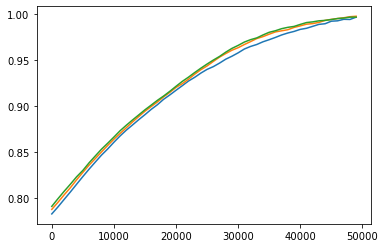

In [59]:
def get_ROC(prob_list, tar, metric='MI_diff', printing=False):
    if metric == 'MI_diff':
        if len(prob_list) > 1:
            out = torch.stack(prob_list).mean(dim=0)
            entrop = torch.sum(torch.log(out**(-out)), dim=1)
            avg_entrop = torch.zeros_like(entrop)
            for i in range(len(prob_list)):
                entrop1 = torch.sum(torch.log(prob_list[i]**(-prob_list[i])), dim=1)
                avg_entrop += entrop1
            avg_entrop /= len(prob_list)
            met = entrop - avg_entrop
        else:
            out = prob_list[0]
            met = torch.sum(torch.log(out**(-out)), dim=1)
    else:
        if len(prob_list) > 1:
            out = torch.stack(prob_list).mean(dim=0)
        else:
            out = prob_list[0]
        met = torch.sum(torch.log(out**(-out)), dim=1)
    
    # sort metric
    sorted_h, ind = torch.sort(met, descending=True)
    sorted_probs = out[ind]
    sorted_tar = tar[ind]
    rejnum = []
    remacc = []
    for i in np.arange(1,50000,1000):
        _,_,acc,all_eq_pcs = get_metrics([(sorted_probs[i:])], [sorted_tar[i:]], [f'avg logits {len(prob_list)} models'], printing=printing, input_softmax=True, num_classes=1000)
        rejnum.append(i)
        remacc.append(acc)
    auuqc = np.array(remacc).sum()/len(remacc)
    print(auuqc)
    return rejnum, remacc, auuqc

x1, acc1, auuqc1 = get_ROC([eq69.softmax(-1), eq42.softmax(-1)], tar)
x2, acc2, auuqc2 = get_ROC([eq69.softmax(-1), eq42.softmax(-1), eq31.softmax(-1)], tar)
x3, acc3, auuqc3 = get_ROC([eq69.softmax(-1), eq42.softmax(-1), eq31.softmax(-1),eq24.softmax(-1)], tar)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(x1, acc1)
plt.plot(x2, acc2)
plt.plot(x3, acc3)



0.9340232157707214
0.9358589720726013
0.9365056347846985
0.9337041163444519
0.9359925031661988
0.9369609272480011


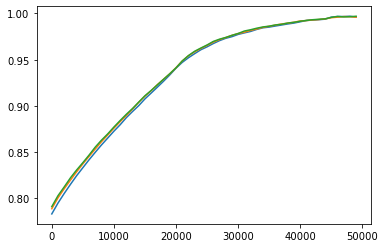

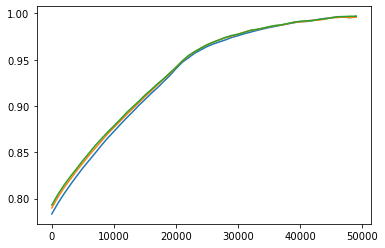

In [30]:
# greedyEI = [eq69,inv31,eq54,eq31,inv,eq42, inv24]
# greedyEE = [eq69,eq31,eq24,eq42,eq54,eq96]

x1, acc1, auuqc1 = get_ROC([eq69.softmax(-1), eq31.softmax(-1)], tar, metric='ent')
x2, acc2, auuqc2 = get_ROC([eq69.softmax(-1), eq31.softmax(-1), eq24.softmax(-1)], tar, metric='ent')
x3, acc3, auuqc3 = get_ROC([eq69.softmax(-1), eq31.softmax(-1), eq24.softmax(-1),eq42.softmax(-1)], tar, metric='ent')

import matplotlib.pyplot as plt
plt.figure()
plt.plot(x1, acc1)
plt.plot(x2, acc2)
plt.plot(x3, acc3)

x1, acc1, auuqc1 = get_ROC([eq69.softmax(-1), inv31.softmax(-1)], tar, metric='ent')
x2, acc2, auuqc2 = get_ROC([eq69.softmax(-1), inv31.softmax(-1), eq54.softmax(-1)], tar, metric='ent')
x3, acc3, auuqc3 = get_ROC([eq69.softmax(-1), inv31.softmax(-1), eq54.softmax(-1),eq31.softmax(-1)], tar, metric='ent')

import matplotlib.pyplot as plt
plt.figure()
plt.plot(x1, acc1)
plt.plot(x2, acc2)
plt.plot(x3, acc3)

In [62]:
# greedyEI = [eq69,inv31,eq54,eq31,inv,eq42, inv24]
# greedyEE = [eq69,eq31,eq24,eq42,eq54,eq96]

_,_,_,all_eq_pcs = get_metrics([(eq69.softmax(-1)+eq31.softmax(-1))/2], [tar], ['EE'], printing=True, input_softmax=True, num_classes=1000)
x1, acc1, auuqc1 = get_ROC([eq69.softmax(-1), eq31.softmax(-1)], tar)
_,_,_,all_eq_pcs = get_metrics([(eq69.softmax(-1)+eq31.softmax(-1)+eq24.softmax(-1))/3], [tar], ['EEE'], printing=True, input_softmax=True, num_classes=1000)
x2, acc2, auuqc2 = get_ROC([eq69.softmax(-1), eq31.softmax(-1), eq24.softmax(-1)], tar)
_,_,_,all_eq_pcs = get_metrics([(eq69.softmax(-1)+eq31.softmax(-1)+eq24.softmax(-1)+eq42.softmax(-1))/4], [tar], ['EEEE'], printing=True, input_softmax=True, num_classes=1000)

x3, acc3, auuqc3 = get_ROC([eq69.softmax(-1), eq31.softmax(-1), eq24.softmax(-1),eq42.softmax(-1)], tar)
_,_,_,all_eq_pcs = get_metrics([(eq69.softmax(-1)+eq31.softmax(-1)+eq24.softmax(-1)+eq42.softmax(-1)+eq96.softmax(-1))/5], [tar], ['EEEEE'], printing=True, input_softmax=True, num_classes=1000)

x4, acc4, auuqc4 = get_ROC([eq69.softmax(-1), eq31.softmax(-1), eq24.softmax(-1),eq42.softmax(-1),eq96.softmax(-1)], tar)


_,_,_,all_eq_pcs = get_metrics([(eq69.softmax(-1)+inv31.softmax(-1))/2], [tar], ['EI'], printing=True, input_softmax=True, num_classes=1000)

xi1, acci1, auuqci1 = get_ROC([eq69.softmax(-1), inv31.softmax(-1)], tar)
_,_,_,all_eq_pcs = get_metrics([(eq69.softmax(-1)+inv31.softmax(-1)+eq54.softmax(-1))/3], [tar], ['EEI'], printing=True, input_softmax=True, num_classes=1000)

xi2, acci2, auuqci2 = get_ROC([eq69.softmax(-1), inv31.softmax(-1), eq54.softmax(-1)], tar)
_,_,_,all_eq_pcs = get_metrics([(eq69.softmax(-1)+inv31.softmax(-1)+eq54.softmax(-1)+eq31.softmax(-1))/4], [tar], ['EEEI'], printing=True, input_softmax=True, num_classes=1000)

xi3, acci3, auuqci3 = get_ROC([eq69.softmax(-1), inv31.softmax(-1), eq54.softmax(-1),eq31.softmax(-1)], tar)
_,_,_,all_eq_pcs = get_metrics([(eq69.softmax(-1)+inv31.softmax(-1)+eq54.softmax(-1)+eq31.softmax(-1)+inv24.softmax(-1))/5], [tar], ['EEEII'], printing=True, input_softmax=True, num_classes=1000)

xi4, acci4, auuqci4 = get_ROC([eq69.softmax(-1), inv31.softmax(-1), eq54.softmax(-1),eq31.softmax(-1),inv24.softmax(-1)], tar)



EE
NLL: 0.8402246236801147 | ECE: 0.01375570820812134 | ECE: tensor([0.0138])
Acc: 0.7831199765205383
0.9201778495311737
EEE
NLL: 0.8173604607582092 | ECE: 0.017493720271084454 | ECE: tensor([0.0175])
Acc: 0.7887399792671204
0.9249775516986847
EEEE
NLL: 0.8055248260498047 | ECE: 0.020629736733883613 | ECE: tensor([0.0206])
Acc: 0.7910000085830688
0.9267912483215333
EEEEE
NLL: 0.8028149008750916 | ECE: 0.02378273024076598 | ECE: tensor([0.0238])
Acc: 0.79093998670578
0.9263439488410949
EI
NLL: 0.8476244807243347 | ECE: 0.015789624023307105 | ECE: tensor([0.0158])
Acc: 0.7833799719810486
0.921446886062622
EEI
NLL: 0.8166572451591492 | ECE: 0.021075211931075886 | ECE: tensor([0.0211])
Acc: 0.7898399829864502
0.9261473858356476
EEEI
NLL: 0.8035669326782227 | ECE: 0.025263717935122533 | ECE: tensor([0.0253])
Acc: 0.7929400205612183
0.9276570844650268
EEEII
NLL: 0.7956450581550598 | ECE: 0.027868556010331964 | ECE: tensor([0.0279])
Acc: 0.7945399880409241
0.9286574423313141


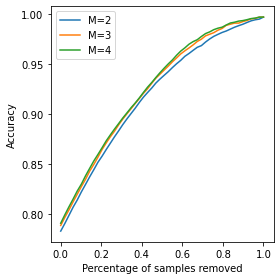

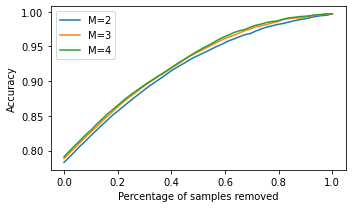

In [85]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.plot(np.linspace(0,1,len(x1)), acc1, label='M=2')
plt.plot(np.linspace(0,1,len(x1)), acc2, label='M=3')
plt.plot(np.linspace(0,1,len(x1)), acc3, label='M=4')
plt.xlabel("Percentage of samples removed")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("auuqc2.pdf")
# plt.yscale("log")

import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
plt.plot(np.linspace(0,1,len(x1)), acc1, label='M=2')
plt.plot(np.linspace(0,1,len(x1)), acc2, label='M=3')
plt.plot(np.linspace(0,1,len(x1)), acc3, label='M=4')
plt.xlabel("Percentage of samples removed")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("auuqc.pdf")

In [14]:
def MI_diff(prob_list, metric='MI_diff'):
    if metric == 'MI_diff':
        if len(prob_list) > 1:
            out = torch.stack(prob_list).mean(dim=0)
            entrop = torch.sum(torch.log(out**(-out)), dim=1)
            avg_entrop = torch.zeros_like(entrop)
            for i in range(len(prob_list)):
                entrop1 = torch.sum(torch.log(prob_list[i]**(-prob_list[i])), dim=1)
                avg_entrop += entrop1
            avg_entrop /= len(prob_list)
            met = entrop - avg_entrop
        else:
            out = prob_list[0]
            met = torch.sum(torch.log(out**(-out)), dim=1)
    return met

eq1 = eq42
eq2 = eq69
eq3 = eq31
ensem2 = torch.stack([eq1.softmax(-1),eq3.softmax(-1)]).mean(dim=0)
ensem3 = torch.stack([eq1.softmax(-1),eq3.softmax(-1),eq2.softmax(-1)]).mean(dim=0)

metric = MI_diff([eq1.softmax(-1)])

sorted_h, ind = torch.sort(metric, descending=True)
sorted_out = eq1.softmax(-1)[ind]
print(sorted_out.shape)
sorted_tar = tar[ind]
rejnum = []
remacc = []
for i in np.arange(1,50000,100):
    _,_,acc,all_eq_pcs = get_metrics([(sorted_out[i:])], [sorted_tar[i:]], ['avg logits 2 models'], printing=False, input_softmax=True, num_classes=1000)
    rejnum.append(i)
    remacc.append(acc)
import matplotlib.pyplot as plt

metric = MI_diff([eq1.softmax(-1),eq3.softmax(-1)])

sorted_h, ind = torch.sort(metric, descending=True)
sorted_out = ensem2[ind]
print(sorted_out.shape)
sorted_tar = tar[ind]
rejnum2 = []
remacc2 = []
for i in np.arange(1,50000,100):
    _,_,acc,all_eq_pcs = get_metrics([(sorted_out[i:])], [sorted_tar[i:]], ['avg logits 2 models'], printing=False, input_softmax=True, num_classes=1000)
    rejnum2.append(i)
    remacc2.append(acc)

metric = MI_diff([eq1.softmax(-1),eq3.softmax(-1), eq2.softmax(-1)])
    
sorted_h, ind = torch.sort(metric, descending=True)
sorted_out = ensem3[ind]
print(sorted_out.shape)
sorted_tar = tar[ind]
rejnum3 = []
remacc3 = []
for i in np.arange(1,50000,100):
    _,_,acc,all_eq_pcs = get_metrics([(sorted_out[i:])], [sorted_tar[i:]], ['avg logits 3 models'], printing=False, input_softmax=True, num_classes=1000)
    rejnum3.append(i)
    remacc3.append(acc)

plt.figure()
plt.plot(rejnum, remacc)
plt.plot(rejnum2, remacc2)
plt.plot(rejnum3, remacc3)

torch.Size([50000, 1000])


KeyboardInterrupt: 

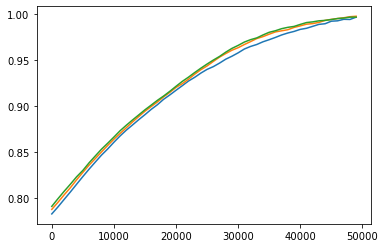

In [27]:
np.interp([0.81,0.99],[0.8,0.9,1.0],[0,0.5,1])
np.linspace(0,1,10)
new_x1 = np.interp(x1, x1, np.linspace(0,1,len(x1)))
print(new_x1)
print(np.array(acc1).sum()/len(acc1))

greedyEI = [eq69,inv31,eq54,eq31,inv,eq42, inv24]
greedyEE = [eq69,eq31,eq24,eq42,eq54,eq96]

[0.         0.02040816 0.04081633 0.06122449 0.08163265 0.10204082
 0.12244898 0.14285714 0.16326531 0.18367347 0.20408163 0.2244898
 0.24489796 0.26530612 0.28571429 0.30612245 0.32653061 0.34693878
 0.36734694 0.3877551  0.40816327 0.42857143 0.44897959 0.46938776
 0.48979592 0.51020408 0.53061224 0.55102041 0.57142857 0.59183673
 0.6122449  0.63265306 0.65306122 0.67346939 0.69387755 0.71428571
 0.73469388 0.75510204 0.7755102  0.79591837 0.81632653 0.83673469
 0.85714286 0.87755102 0.89795918 0.91836735 0.93877551 0.95918367
 0.97959184 1.        ]
0.9210170650482178


In [143]:
eq69 = torch.load(f"./logits_files/eq69.pth")
eq42 = torch.load(f"./logits_files/eq42.pth")
eq31 = torch.load(f"./logits_files/eq31.pth")
eq24 = torch.load(f"./logits_files/eq24.pth")
eq54 = torch.load(f"./logits_files/eq54.pth")
eq96 = torch.load(f"./logits_files/eq96.pth")
tar = torch.load(f"./logits_files/targets.pth")

baseR = torch.load(f"./logits_files/baseR.pth")
base31 = torch.load(f"./logits_files/base31.pth")
base24 = torch.load(f"./logits_files/base24.pth")
base69 = torch.load(f"./logits_files/base69.pth")

inv = torch.load(f"./logits_files/inv.pth")
inv31 = torch.load(f"./logits_files/inv31.pth")
inv24 = torch.load(f"./logits_files/inv24.pth")
inv69 = torch.load(f"./logits_files/inv69.pth")

m1 = torch.load(f"./logits_files/sup/m1.pth")
m2 = torch.load(f"./logits_files/sup/m2.pth")
m3 = torch.load(f"./logits_files/sup/m3.pth")


In [141]:
class KLD(torch.nn.Module):
    def __init__(self):
        super(KLD, self).__init__()
        self.kl = torch.nn.KLDivLoss(reduction='sum', log_target=True)

    def forward(self, p: torch.tensor, q: torch.tensor):
        p = F.log_softmax(p, dim=-1)
        q = F.log_softmax(q, dim=-1)
        return self.kl(p,q)

kl_div = KLD()

def compute_pair_consensus(pair_preds, target):
    agree = (pair_preds[0] == pair_preds[1])
    agree_correct = agree & (pair_preds[0] == target)
    agree_wrong = agree & (pair_preds[0] != target)
    disagree = (pair_preds[0] != pair_preds[1])
    disagree_both_wrong = disagree & (pair_preds[0] != target) & (pair_preds[1] != target)
    disagree_one_correct = disagree & (pair_preds[0] != target) & (pair_preds[1] == target) 
    disagree_one_correct2 = disagree & (pair_preds[1] != target) & (pair_preds[0] == target) 
    return agree.sum(), disagree.sum(), agree_correct.sum(), agree_wrong.sum(), disagree_both_wrong.sum(), disagree_one_correct.sum()+disagree_one_correct2.sum()

def get_div_metrics(output1,output2,output3,target):
    preds = torch.stack([output1,output2,output3])
    avg_std_logits = torch.std(preds, dim=0).mean(dim=-1).mean() # std over members, mean over classes, sum over samples (mean taken later))
    avg_std = torch.std(preds.softmax(-1), dim=0).mean(dim=-1).mean() # std over members, mean over classes, sum over samples (mean taken later))
    _, all_preds = preds.max(-1)
    ag_p, dag_p, ag_c_p, ag_w_p, dag_w_p, dag_c_p = 0, 0, 0, 0, 0, 0
    kld = 0.
    pairs = ([0,1], [0,2], [1,2])
    for p in pairs:
        ag, dag, ag_c, ag_w, dag_w, dag_c = compute_pair_consensus(all_preds[p,:], target)
        ag_p += ag
        dag_p += dag
        ag_c_p += ag_c
        ag_w_p += ag_w
        dag_c_p += dag_c
        dag_w_p += dag_w
        kld += kl_div(preds[p[0]], preds[p[1]])

    ag_sum = ag_p/len(pairs)
    dag_sum = dag_p/len(pairs)
    ag_c_sum = ag_c_p/len(pairs)
    ag_w_sum = ag_w_p/len(pairs)
    dag_c_sum = dag_c_p/len(pairs)
    dag_w_sum = dag_w_p/len(pairs)
    kld_sum = kld/len(pairs)
    print(f"Diversity agree: {ag_sum/len(output1)} | disagree: {dag_sum/len(output1)}") 
    print(f"Ensemble Variance Logits: {avg_std_logits} ") 
    print(f"Ensemble Variance: {avg_std}") 
    print(f"KL div: {kld_sum/len(output1)}") 
    return ag_sum/len(output1), dag_sum/len(output1), kld_sum/len(output1), avg_std_logits, avg_std

eq69
NLL: 0.9093856811523438 | ECE: 0.0337492092939466 | ECE: tensor([0.0337])
Acc: 0.7688199877738953
eq31
NLL: 0.9056292772293091 | ECE: 0.03064089876106011 | ECE: tensor([0.0306])
Acc: 0.7682399749755859
inv
NLL: 0.9599095582962036 | ECE: 0.03850952307265253 | ECE: tensor([0.0385])
Acc: 0.7601400017738342


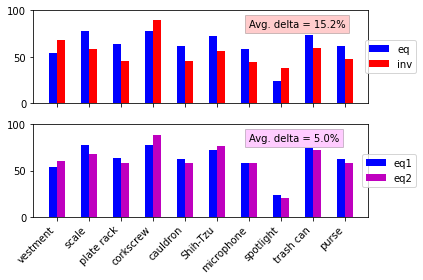

In [140]:
_,_,_,[eq69_pc] = get_metrics([eq69], [tar], ['eq69'], printing=True, input_softmax=False, num_classes=1000)
_,_,_,[eq31_pc] = get_metrics([eq31], [tar], ['eq31'], printing=True, input_softmax=False, num_classes=1000)

_,_,_,[inv_pc] = get_metrics([inv], [tar], ['inv'], printing=True, input_softmax=False, num_classes=1000)

acc_pc_eq = eq69_pc.cpu()
acc_pc_inv = inv_pc.cpu()
# acc_pc_bei = acc_pc_bei.cpu()
y = torch.stack([acc_pc_eq,acc_pc_inv], dim=-1)*100

ystd = torch.std(y,dim=-1)
val, ind = torch.sort(ystd, descending=True)

from imagenet_stubs.imagenet_2012_labels import label_to_name
s_labs = ['vestment', 'scale', 'plate rack', 'corkscrew', 'cauldron', 'Shih-Tzu', 'microphone', 'spotlight', 'trash can', 'purse']
sind = np.array([887, 778, 729, 512,469, 155,650, 818, 412, 748])
# sind = ind.numpy()
# sind = ind.numpy()[:30]

idxs = np.arange(len(sind))
fig = plt.figure(figsize=(6,4))
# plt.ylabel("Per class accuracy (%)")
# plt.xlabel("Class")

ax = plt.subplot(211)
ax.set_xticks(idxs)
xticks = [f'{j}: {label_to_name(j)}' for j in sind]
ax.bar(idxs-0.125, y[sind,0], width=0.25, color='b', align='center', label='eq')
ax.bar(idxs+0.125, y[sind,1], width=0.25, color='r', align='center', label='inv')
# ax.bar(idxs+0.2, y[sind,0], width=0.2, color='r', align='center', label='inv')
# Set number of ticks for x-axis
# ax.set_xticks(xticks)
# Set ticks labels for x-axis
# ax.set_xticklabels(xticks, rotation=45, ha='right', fontsize=8)
plt.legend(loc='right',bbox_to_anchor=(1.16, 0.5))
plt.tight_layout()
plt.ylim((0,100))
ax.set_yticks(np.linspace(0,100,3))
ax.set_xticklabels([])
plt.text(6,82,'Avg. delta = 15.2%', bbox=dict(facecolor='red', alpha=0.2))

acc_pc_eq = eq69_pc.cpu()
acc_pc_eq2 = eq31_pc.cpu()
y2 = torch.stack([acc_pc_eq, acc_pc_eq2], dim=-1)*100

ax = plt.subplot(212)
ax.set_xticks(idxs)
# xticks = [f'{j}: {label_to_name(j)}' for j in sind]
xticks = s_labs
ax.bar(idxs-0.125, y2[sind,0], width=0.25, color='b', align='center', label='eq1')
ax.bar(idxs+0.125, y2[sind,1], width=0.25, color='m', align='center', label='eq2')
# Set number of ticks for x-axis
# ax.set_xticks(xticks)
# Set ticks labels for x-axis

ax.set_xticklabels(xticks, rotation=45, ha='right', fontsize=10)
ax.set_yticks(np.linspace(0,100,3))

plt.legend(loc='right',bbox_to_anchor=(1.16, 0.5))
plt.tight_layout()
plt.ylim((0,100))
plt.text(6,82,'Avg. delta = 5.0%', bbox=dict(facecolor='magenta', alpha=0.2))
plt.savefig('ei_vs_ee_selected_bars.pdf')


In [142]:
get_div_metrics(m1,m2,m3,tar)

NameError: name 'm1' is not defined

In [111]:
sind
[f'{j}: {label_to_name(j)}' for j in sind]

['459: brassiere, bra, bandeau',
 '778: scale, weighing machine',
 '729: plate rack',
 '504: coffee mug',
 '469: caldron, cauldron',
 '155: Shih-Tzu',
 '442: bell cote, bell cot',
 '559: folding chair',
 '843: swing',
 '264: Cardigan, Cardigan Welsh corgi',
 '445: bikini, two-piece',
 '650: microphone, mike',
 '998: ear, spike, capitulum',
 '748: purse',
 '32: tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui',
 '449: boathouse',
 '818: spotlight, spot',
 '412: ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin',
 '887: vestment',
 '872: tripod',
 '402: acoustic guitar',
 '636: mailbag, postbag',
 '512: corkscrew, bottle screw',
 '761: remote control, remote',
 '577: gong, tam-tam',
 '165: black-and-tan coonhound',
 '583: guillotine',
 '637: mailbox, letter box',
 '367: chimpanzee, chimp, Pan troglodytes',
 '860: tobacco shop, tobacconist shop, tobacconist']

In [134]:
print(torch.abs(y[sind,0] - y[sind,1]).mean())
print(torch.abs(y2[sind,0] - y2[sind,1]).mean())


tensor(15.2000)
tensor(5.)


In [9]:

num_classes=1000
all_eq = [eq69, eq42, eq31, eq24, eq54, eq96]
tars = [tar, tar, tar, tar, tar, tar]
names = ['eq69', 'eq42', 'eq31', 'eq24', 'eq54', 'eq96']
_,_,_,all_eq_pcs = get_metrics(all_eq, tars, names, printing=True, input_softmax=False, num_classes=1000)

all_base = [baseR, base69, base31, base24]
tars = [tar, tar, tar, tar]
names = ['baseR', 'base69','base31', 'base24']
_,_,_,all_base_pcs = get_metrics(all_base, tars, names, printing=True, input_softmax=False, num_classes=1000)

all_inv = [inv, inv69, inv31, inv24]
tars = [tar, tar, tar, tar]
names = ['inv', 'inv69','inv31', 'inv24']
_,_,_,all_inv_pcs = get_metrics(all_inv, tars, names, printing=True, input_softmax=False, num_classes=1000)


eq69
NLL: 0.9093856811523438 | ECE: 0.0337492092939466 | ECE: tensor([0.0337])
Acc: 0.7688199877738953
eq42
NLL: 0.9061235189437866 | ECE: 0.030388316879942992 | ECE: tensor([0.0304])
Acc: 0.7691799998283386
eq31
NLL: 0.9056292772293091 | ECE: 0.03064089876106011 | ECE: tensor([0.0306])
Acc: 0.7682399749755859
eq24
NLL: 0.9061529636383057 | ECE: 0.034896882147118426 | ECE: tensor([0.0349])
Acc: 0.7687000036239624
eq54
NLL: 0.9062519669532776 | ECE: 0.0299696643065102 | ECE: tensor([0.0300])
Acc: 0.7698000073432922
eq96
NLL: 0.9118061065673828 | ECE: 0.01592051938500256 | ECE: tensor([0.0159])
Acc: 0.7660800218582153
baseR
NLL: 0.92169588804245 | ECE: 0.02982491346189754 | ECE: tensor([0.0298])
Acc: 0.7664600014686584
base69
NLL: 0.9307573437690735 | ECE: 0.03674569608774035 | ECE: tensor([0.0367])
Acc: 0.7646600008010864
base31
NLL: 0.9237776398658752 | ECE: 0.03522912882274018 | ECE: tensor([0.0352])
Acc: 0.7649199962615967
base24
NLL: 0.9240397810935974 | ECE: 0.03593396563421934 | E

In [88]:
get_classwise(all_base_pcs[0], all_inv_pcs[0], all_eq_pcs[0], num_classes=1000)
get_classwise_IE(all_inv_pcs[0], all_eq_pcs[0], num_classes=1000)

use order B, I, E
all equal best: 5.4%
B,I equal best: 5.0%
B,E equal best: 9.0%
I,E equal best: 5.2%
B uniquely best: 27.0%
I uniquely best: 21.0%
E uniquely best: 27.4%
use order I, E
all equal best: 17.3%
I uniquely best: 34.5%
E uniquely best: 48.2%


In [77]:
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=1, num_B=0, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=2, num_B=0, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=3, num_B=0, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=4, num_B=0, num_I=0)


E
NLL: 0.9073 +/- 0.0017
ECE: 0.0333 +/- 0.0019
Acc: 0.7688 +/- 0.0003
EE
NLL: 0.8416 +/- 0.0033
ECE: 0.0163 +/- 0.0005
Acc: 0.7823 +/- 0.0007
EEE
NLL: 0.8185 +/- 0.0028
ECE: 0.0186 +/- 0.0010
Acc: 0.7876 +/- 0.0009
EEEE
NLL: 0.8099 +/- 0.0022
ECE: 0.0213 +/- 0.0014
Acc: 0.7889 +/- 0.0004


In [78]:
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=0, num_B=1, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=0, num_B=2, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=0, num_B=3, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=0, num_B=4, num_I=0)


B
NLL: 0.9280 +/- 0.0034
ECE: 0.0367 +/- 0.0008
Acc: 0.7646 +/- 0.0003
BB
NLL: 0.8544 +/- 0.0012
ECE: 0.0157 +/- 0.0007
Acc: 0.7800 +/- 0.0008
BBB
NLL: 0.8307 +/- 0.0008
ECE: 0.0188 +/- 0.0010
Acc: 0.7856 +/- 0.0005
BBBB
NLL: 0.8186 +/- 0.0000
ECE: 0.0219 +/- 0.0000
Acc: 0.7887 +/- 0.0000


In [66]:
# 1 model
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=1, num_B=0, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=0, num_B=1, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=0, num_B=0, num_I=1)

E
NLL: 0.9078 +/- 0.0024
ECE: 0.0281 +/- 0.0063
Acc: 0.7684 +/- 0.0013
B
NLL: 0.9226 +/- 0.0011
ECE: 0.0321 +/- 0.0028
Acc: 0.7657 +/- 0.0010
I
NLL: 0.9655 +/- 0.0047
ECE: 0.0463 +/- 0.0040
Acc: 0.7594 +/- 0.0004


In [57]:
# 2 models
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=2, num_B=0, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=1, num_B=0, num_I=1)

0.917552832365036
0.9210170650482178
0.9205694258213043
0.918105605840683
0.9199481451511383
EE
NLL: 0.8434 +/- 0.0038
ECE: 0.0150 +/- 0.0010
Acc: 0.7820 +/- 0.0008
AUUQC: 0.919439 +/- 0.001368
0.92242445230484
0.9217429745197296
0.9210129797458648
0.9217754411697388
0.9179157197475434
EI
NLL: 0.8463 +/- 0.0035
ECE: 0.0146 +/- 0.0006
Acc: 0.7817 +/- 0.0013
AUUQC: 0.920974 +/- 0.001593


In [55]:
# 3 models
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=3, num_B=0, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=2, num_B=0, num_I=1)

0.9251684522628785
0.9230803835391999
0.9226892268657685
0.9226892268657685
0.924967097043991
EEE
NLL: 0.8213 +/- 0.0030
ECE: 0.0174 +/- 0.0010
Acc: 0.7863 +/- 0.0008
AUUQC: 0.923719 +/- 0.001112
0.924110199213028
0.9262438130378723
0.9226541590690612
0.9241497206687928
0.9257439875602722
EEI
NLL: 0.8203 +/- 0.0033
ECE: 0.0219 +/- 0.0020
Acc: 0.7878 +/- 0.0007
AUUQC: 0.924580 +/- 0.001284


In [56]:
# 4 models
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=4, num_B=0, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=2, num_B=0, num_I=2)

0.9258793985843659
0.9258793985843659
0.925422215461731
0.9273972761631012
0.9249031710624694
EEEE
NLL: 0.8103 +/- 0.0022
ECE: 0.0216 +/- 0.0008
Acc: 0.7895 +/- 0.0009
AUUQC: 0.925896 +/- 0.000832
0.9274159777164459
0.9266562211513519
0.9271940863132477
0.9278929936885834
0.9266080808639526
EEII
NLL: 0.8056 +/- 0.0011
ECE: 0.0237 +/- 0.0004
Acc: 0.7909 +/- 0.0004
AUUQC: 0.927153 +/- 0.000482


In [58]:
# 5 models
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=5, num_B=0, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=3, num_B=0, num_I=2)

0.9267890679836274
0.9277769207954407
0.9270445430278778
0.9263663101196289
0.9265766191482544
EEEEE
NLL: 0.8023 +/- 0.0018
ECE: 0.0235 +/- 0.0009
Acc: 0.7912 +/- 0.0003
AUUQC: 0.926911 +/- 0.000488
0.9279619419574737
0.9274400055408478
0.9284610176086425
0.9272146761417389
0.9282303941249848
EEEII
NLL: 0.7980 +/- 0.0018
ECE: 0.0275 +/- 0.0008
Acc: 0.7931 +/- 0.0005
AUUQC: 0.927862 +/- 0.000469


In [90]:
# ImageNet-V2
ds = 'v2'
num_classes=1000

eq69 = torch.load(f"./logits_files/eq69_eval_on_{ds}.pth")
eq42 = torch.load(f"./logits_files/eq42_eval_on_{ds}.pth")
eq31 = torch.load(f"./logits_files/eq31_eval_on_{ds}.pth")
eq24 = torch.load(f"./logits_files/eq24_eval_on_{ds}.pth")
eq54 = torch.load(f"./logits_files/eq54_eval_on_{ds}.pth")
eq96 = torch.load(f"./logits_files/eq96_eval_on_{ds}.pth")
tar = torch.load(f"./logits_files/{ds}_targets.pth")

baseR = torch.load(f"./logits_files/baseR_eval_on_{ds}.pth")
base31 = torch.load(f"./logits_files/base31_eval_on_{ds}.pth")
base24 = torch.load(f"./logits_files/base24_eval_on_{ds}.pth")
base69 = torch.load(f"./logits_files/base69_eval_on_{ds}.pth")

inv = torch.load(f"./logits_files/inv_eval_on_{ds}.pth")
inv31 = torch.load(f"./logits_files/inv31_eval_on_{ds}.pth")
inv24 = torch.load(f"./logits_files/inv24_eval_on_{ds}.pth")
inv69 = torch.load(f"./logits_files/inv69_eval_on_{ds}.pth")

all_eq = [eq69, eq42, eq31, eq24, eq54, eq96]
tars = [tar, tar, tar, tar, tar, tar]
names = ['eq69', 'eq42', 'eq31', 'eq24', 'eq54', 'eq96']
_,_,_,all_eq_pcs = get_metrics(all_eq, tars, names, printing=False, input_softmax=False, num_classes=1000)

all_base = [baseR, base69, base31, base24]
tars = [tar, tar, tar, tar]
names = ['baseR', 'base69','base31', 'base24']
_,_,_,all_base_pcs = get_metrics(all_base, tars, names, printing=False, input_softmax=False, num_classes=1000)

all_inv = [inv, inv69, inv31, inv24]
tars = [tar, tar, tar, tar]
names = ['inv', 'inv69','inv31', 'inv24']
_,_,_,all_inv_pcs = get_metrics(all_inv, tars, names, printing=False, input_softmax=False, num_classes=1000)

# 1 model
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=1, num_B=0, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=0, num_B=1, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=0, num_B=0, num_I=1)

# 2 models
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=2, num_B=0, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=1, num_B=0, num_I=1)

# 3 models
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=3, num_B=0, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=2, num_B=0, num_I=1)

# 4 models
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=4, num_B=0, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=3, num_B=0, num_I=1)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=2, num_B=0, num_I=2)


get_classwise(all_base_pcs[0], all_inv_pcs[0], all_eq_pcs[0], num_classes=num_classes)
get_classwise_IE(all_inv_pcs[0], all_eq_pcs[0], num_classes=num_classes)

E
NLL: 1.5568 +/- 0.0041
ECE: 0.0804 +/- 0.0009
Acc: 0.6455 +/- 0.0014
B
NLL: 1.5938 +/- 0.0068
ECE: 0.0850 +/- 0.0017
Acc: 0.6400 +/- 0.0032
I
NLL: 1.6894 +/- 0.0013
ECE: 0.1030 +/- 0.0002
Acc: 0.6315 +/- 0.0018
EE
NLL: 1.4482 +/- 0.0035
ECE: 0.0420 +/- 0.0028
Acc: 0.6609 +/- 0.0016
EI
NLL: 1.4737 +/- 0.0046
ECE: 0.0429 +/- 0.0024
Acc: 0.6593 +/- 0.0027
EEE
NLL: 1.4101 +/- 0.0003
ECE: 0.0307 +/- 0.0015
Acc: 0.6661 +/- 0.0012
EEI
NLL: 1.4190 +/- 0.0026
ECE: 0.0271 +/- 0.0019
Acc: 0.6666 +/- 0.0021
EEEE
NLL: 1.3908 +/- 0.0016
ECE: 0.0242 +/- 0.0023
Acc: 0.6709 +/- 0.0011
EEEI
NLL: 1.3950 +/- 0.0018
ECE: 0.0222 +/- 0.0015
Acc: 0.6709 +/- 0.0016
EEII
NLL: 1.4056 +/- 0.0026
ECE: 0.0243 +/- 0.0016
Acc: 0.6689 +/- 0.0017
use order B, I, E
all equal best: 21.6%
B,I equal best: 8.4%
B,E equal best: 12.1%
I,E equal best: 9.9%
B uniquely best: 15.7%
I uniquely best: 12.4%
E uniquely best: 19.9%
use order I, E
all equal best: 40.2%
I uniquely best: 23.7%
E uniquely best: 36.1%


In [92]:
# ImageNet-Sketch
ds = 'sketch'
num_classes=1000

eq69 = torch.load(f"./logits_files/eq69_eval_on_{ds}.pth")
eq42 = torch.load(f"./logits_files/eq42_eval_on_{ds}.pth")
eq31 = torch.load(f"./logits_files/eq31_eval_on_{ds}.pth")
eq24 = torch.load(f"./logits_files/eq24_eval_on_{ds}.pth")
eq54 = torch.load(f"./logits_files/eq54_eval_on_{ds}.pth")
eq96 = torch.load(f"./logits_files/eq96_eval_on_{ds}.pth")
tar = torch.load(f"./logits_files/{ds}_targets.pth")

baseR = torch.load(f"./logits_files/baseR_eval_on_{ds}.pth")
base31 = torch.load(f"./logits_files/base31_eval_on_{ds}.pth")
base24 = torch.load(f"./logits_files/base24_eval_on_{ds}.pth")
base69 = torch.load(f"./logits_files/base69_eval_on_{ds}.pth")

inv = torch.load(f"./logits_files/inv_eval_on_{ds}.pth")
inv31 = torch.load(f"./logits_files/inv31_eval_on_{ds}.pth")
inv24 = torch.load(f"./logits_files/inv24_eval_on_{ds}.pth")
inv69 = torch.load(f"./logits_files/inv69_eval_on_{ds}.pth")

all_eq = [eq69, eq42, eq31, eq24, eq54, eq96]
tars = [tar, tar, tar, tar, tar, tar]
names = ['eq69', 'eq42', 'eq31', 'eq24', 'eq54', 'eq96']
_,_,_,all_eq_pcs = get_metrics(all_eq, tars, names, printing=False, input_softmax=False, num_classes=1000)

all_base = [baseR, base69, base31, base24]
tars = [tar, tar, tar, tar]
names = ['baseR', 'base69','base31', 'base24']
_,_,_,all_base_pcs = get_metrics(all_base, tars, names, printing=False, input_softmax=False, num_classes=1000)

all_inv = [inv, inv69, inv31, inv24]
tars = [tar, tar, tar, tar]
names = ['inv', 'inv69','inv31', 'inv24']
_,_,_,all_inv_pcs = get_metrics(all_inv, tars, names, printing=False, input_softmax=False, num_classes=1000)

# 1 model
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=1, num_B=0, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=0, num_B=1, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=0, num_B=0, num_I=1)

# 2 models
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=2, num_B=0, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=1, num_B=0, num_I=1)

# 3 models
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=3, num_B=0, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=2, num_B=0, num_I=1)

# 4 models
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=4, num_B=0, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=3, num_B=0, num_I=1)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=2, num_B=0, num_I=2)


get_classwise(all_base_pcs[0], all_inv_pcs[0], all_eq_pcs[0], num_classes=num_classes)
get_classwise_IE(all_inv_pcs[0], all_eq_pcs[0], num_classes=num_classes)

E
NLL: 5.1301 +/- 0.0480
ECE: 0.2432 +/- 0.0038
Acc: 0.2402 +/- 0.0017
B
NLL: 5.1780 +/- 0.0734
ECE: 0.2367 +/- 0.0106
Acc: 0.2365 +/- 0.0031
I
NLL: 5.6315 +/- 0.0556
ECE: 0.2707 +/- 0.0056
Acc: 0.2120 +/- 0.0039
EE
NLL: 4.7596 +/- 0.0450
ECE: 0.1781 +/- 0.0041
Acc: 0.2549 +/- 0.0023
EI
NLL: 4.8908 +/- 0.0647
ECE: 0.1762 +/- 0.0055
Acc: 0.2457 +/- 0.0029
EEE
NLL: 4.6272 +/- 0.0122
ECE: 0.1556 +/- 0.0021
Acc: 0.2611 +/- 0.0009
EEI
NLL: 4.7108 +/- 0.0189
ECE: 0.1508 +/- 0.0012
Acc: 0.2575 +/- 0.0008
EEEE
NLL: 4.5596 +/- 0.0085
ECE: 0.1424 +/- 0.0019
Acc: 0.2644 +/- 0.0006
EEEI
NLL: 4.6224 +/- 0.0306
ECE: 0.1385 +/- 0.0015
Acc: 0.2620 +/- 0.0011
EEII
NLL: 4.6873 +/- 0.0282
ECE: 0.1384 +/- 0.0015
Acc: 0.2566 +/- 0.0016
use order B, I, E
all equal best: 11.3%
B,I equal best: 3.3%
B,E equal best: 5.9%
I,E equal best: 4.3%
B uniquely best: 29.4%
I uniquely best: 15.3%
E uniquely best: 30.5%
use order I, E
all equal best: 21.2%
I uniquely best: 25.7%
E uniquely best: 53.1%


In [98]:
# ImageNet-Adv
ds = 'adv'
num_classes=200

eq69 = torch.load(f"./logits_files/eq69_eval_on_{ds}.pth")
eq42 = torch.load(f"./logits_files/eq42_eval_on_{ds}.pth")
eq31 = torch.load(f"./logits_files/eq31_eval_on_{ds}.pth")
eq24 = torch.load(f"./logits_files/eq24_eval_on_{ds}.pth")
eq54 = torch.load(f"./logits_files/eq54_eval_on_{ds}.pth")
eq96 = torch.load(f"./logits_files/eq96_eval_on_{ds}.pth")
tar = torch.load(f"./logits_files/{ds}_targets.pth")

baseR = torch.load(f"./logits_files/baseR_eval_on_{ds}.pth")
base31 = torch.load(f"./logits_files/base31_eval_on_{ds}.pth")
base24 = torch.load(f"./logits_files/base24_eval_on_{ds}.pth")
base69 = torch.load(f"./logits_files/base69_eval_on_{ds}.pth")

inv = torch.load(f"./logits_files/inv_eval_on_{ds}.pth")
inv31 = torch.load(f"./logits_files/inv31_eval_on_{ds}.pth")
inv24 = torch.load(f"./logits_files/inv24_eval_on_{ds}.pth")
inv69 = torch.load(f"./logits_files/inv69_eval_on_{ds}.pth")

all_eq = [eq69, eq42, eq31, eq24, eq54, eq96]
tars = [tar, tar, tar, tar, tar, tar]
names = ['eq69', 'eq42', 'eq31', 'eq24', 'eq54', 'eq96']
_,_,_,all_eq_pcs = get_metrics(all_eq, tars, names, printing=False, input_softmax=False, num_classes=num_classes)

all_base = [baseR, base69, base31, base24]
tars = [tar, tar, tar, tar]
names = ['baseR', 'base69','base31', 'base24']
_,_,_,all_base_pcs = get_metrics(all_base, tars, names, printing=False, input_softmax=False, num_classes=num_classes)

all_inv = [inv, inv69, inv31, inv24]
tars = [tar, tar, tar, tar]
names = ['inv', 'inv69','inv31', 'inv24']
_,_,_,all_inv_pcs = get_metrics(all_inv, tars, names, printing=False, input_softmax=False, num_classes=num_classes)

# 1 model
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=1, num_B=0, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=0, num_B=1, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=0, num_B=0, num_I=1)

# 2 models
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=2, num_B=0, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=1, num_B=0, num_I=1)

# 3 models
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=3, num_B=0, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=2, num_B=0, num_I=1)

# 4 models
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=4, num_B=0, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=3, num_B=0, num_I=1)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=2, num_B=0, num_I=2)


get_classwise(all_base_pcs[0], all_inv_pcs[0], all_eq_pcs[0], num_classes=num_classes)
get_classwise_IE(all_inv_pcs[0], all_eq_pcs[0], num_classes=num_classes)

E
NLL: 5.5136 +/- 0.0805
ECE: 0.4708 +/- 0.0084
Acc: 0.0664 +/- 0.0033
B
NLL: 5.7095 +/- 0.0428
ECE: 0.4840 +/- 0.0072
Acc: 0.0596 +/- 0.0008
I
NLL: 5.9093 +/- 0.0367
ECE: 0.5009 +/- 0.0017
Acc: 0.0620 +/- 0.0022
EE
NLL: 5.0949 +/- 0.0297
ECE: 0.4176 +/- 0.0021
Acc: 0.0680 +/- 0.0018
EI
NLL: 5.1924 +/- 0.0391
ECE: 0.4205 +/- 0.0017
Acc: 0.0662 +/- 0.0032
EEE
NLL: 4.9638 +/- 0.0214
ECE: 0.4052 +/- 0.0021
Acc: 0.0673 +/- 0.0010
EEI
NLL: 4.9621 +/- 0.0133
ECE: 0.3991 +/- 0.0024
Acc: 0.0674 +/- 0.0020
EEEE
NLL: 4.8659 +/- 0.0043
ECE: 0.3940 +/- 0.0008
Acc: 0.0678 +/- 0.0007
EEEI
NLL: 4.8637 +/- 0.0169
ECE: 0.3910 +/- 0.0024
Acc: 0.0667 +/- 0.0015
EEII
NLL: 4.9003 +/- 0.0146
ECE: 0.3916 +/- 0.0022
Acc: 0.0654 +/- 0.0017
use order B, I, E
all equal best: 17.5%
B,I equal best: 6.5%
B,E equal best: 5.5%
I,E equal best: 11.5%
tensor(200)
B uniquely best: 12.5%
I uniquely best: 23.5%
E uniquely best: 23.0%
use order I, E
all equal best: 36.5%
I uniquely best: 32.5%
E uniquely best: 31.0%


In [99]:
# ImageNet-R
ds = 'rend'
eq69 = torch.load(f"./logits_files/eq69_eval_on_{ds}.pth")
eq42 = torch.load(f"./logits_files/eq42_eval_on_{ds}.pth")
eq31 = torch.load(f"./logits_files/eq31_eval_on_{ds}.pth")
eq24 = torch.load(f"./logits_files/eq24_eval_on_{ds}.pth")
eq54 = torch.load(f"./logits_files/eq54_eval_on_{ds}.pth")
eq96 = torch.load(f"./logits_files/eq96_eval_on_{ds}.pth")
tar = torch.load(f"./logits_files/{ds}_targets.pth")

baseR = torch.load(f"./logits_files/baseR_eval_on_{ds}.pth")
base31 = torch.load(f"./logits_files/base31_eval_on_{ds}.pth")
base24 = torch.load(f"./logits_files/base24_eval_on_{ds}.pth")
base69 = torch.load(f"./logits_files/base69_eval_on_{ds}.pth")

inv = torch.load(f"./logits_files/inv_eval_on_{ds}.pth")
inv31 = torch.load(f"./logits_files/inv31_eval_on_{ds}.pth")
inv24 = torch.load(f"./logits_files/inv24_eval_on_{ds}.pth")
inv69 = torch.load(f"./logits_files/inv69_eval_on_{ds}.pth")

num_classes=200
all_eq = [eq69, eq42, eq31, eq24, eq54, eq96]
tars = [tar, tar, tar, tar, tar, tar]
names = ['eq69', 'eq42', 'eq31', 'eq24', 'eq54', 'eq96']
_,_,_,all_eq_pcs = get_metrics(all_eq, tars, names, printing=False, input_softmax=False, num_classes=num_classes)

all_base = [baseR, base69, base31, base24]
tars = [tar, tar, tar, tar]
names = ['baseR', 'base69','base31', 'base24']
_,_,_,all_base_pcs = get_metrics(all_base, tars, names, printing=False, input_softmax=False, num_classes=num_classes)

all_inv = [inv, inv69, inv31, inv24]
tars = [tar, tar, tar, tar]
names = ['inv', 'inv69','inv31', 'inv24']
_,_,_,all_inv_pcs = get_metrics(all_inv, tars, names, printing=False, input_softmax=False, num_classes=num_classes)

# 1 model
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=1, num_B=0, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=0, num_B=1, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=0, num_B=0, num_I=1)

# 2 models
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=2, num_B=0, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=1, num_B=0, num_I=1)

# 3 models
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=3, num_B=0, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=2, num_B=0, num_I=1)

# 4 models
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=4, num_B=0, num_I=0)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=3, num_B=0, num_I=1)
ensem_BEI(all_eq,all_base,all_inv,tar,num_E=2, num_B=0, num_I=2)


get_classwise(all_base_pcs[0], all_inv_pcs[0], all_eq_pcs[0], num_classes=num_classes)
get_classwise_IE(all_inv_pcs[0], all_eq_pcs[0], num_classes=num_classes)

E
NLL: 3.9422 +/- 0.0472
ECE: 0.2063 +/- 0.0096
Acc: 0.3583 +/- 0.0028
B
NLL: 4.0272 +/- 0.0125
ECE: 0.2119 +/- 0.0058
Acc: 0.3510 +/- 0.0017
I
NLL: 4.3708 +/- 0.0362
ECE: 0.2458 +/- 0.0039
Acc: 0.3241 +/- 0.0036
EE
NLL: 3.7025 +/- 0.0254
ECE: 0.1495 +/- 0.0034
Acc: 0.3760 +/- 0.0017
EI
NLL: 3.8320 +/- 0.0195
ECE: 0.1566 +/- 0.0027
Acc: 0.3648 +/- 0.0030
EEE
NLL: 3.6110 +/- 0.0078
ECE: 0.1320 +/- 0.0017
Acc: 0.3831 +/- 0.0013
EEI
NLL: 3.6542 +/- 0.0135
ECE: 0.1275 +/- 0.0019
Acc: 0.3769 +/- 0.0011
EEEE
NLL: 3.5513 +/- 0.0057
ECE: 0.1193 +/- 0.0009
Acc: 0.3877 +/- 0.0010
EEEI
NLL: 3.5924 +/- 0.0179
ECE: 0.1142 +/- 0.0022
Acc: 0.3837 +/- 0.0021
EEII
NLL: 3.6482 +/- 0.0106
ECE: 0.1183 +/- 0.0019
Acc: 0.3764 +/- 0.0014
use order B, I, E
all equal best: 0.0%
B,I equal best: 0.5%
B,E equal best: 6.0%
I,E equal best: 2.5%
tensor(200)
B uniquely best: 33.5%
I uniquely best: 12.0%
E uniquely best: 45.5%
use order I, E
all equal best: 5.5%
I uniquely best: 18.0%
E uniquely best: 76.5%


In [102]:
## Eval on subset
eq69 = torch.load(f"./logits_files/eq69.pth")
eq42 = torch.load(f"./logits_files/eq42.pth")
eq31 = torch.load(f"./logits_files/eq31.pth")
eq24 = torch.load(f"./logits_files/eq24.pth")
eq54 = torch.load(f"./logits_files/eq54.pth")
eq96 = torch.load(f"./logits_files/eq96.pth")
tar = torch.load(f"./logits_files/targets.pth")

baseR = torch.load(f"./logits_files/baseR.pth")
base31 = torch.load(f"./logits_files/base31.pth")
base24 = torch.load(f"./logits_files/base24.pth")
base69 = torch.load(f"./logits_files/base69.pth")

inv = torch.load(f"./logits_files/inv.pth")
inv31 = torch.load(f"./logits_files/inv31.pth")
inv24 = torch.load(f"./logits_files/inv24.pth")
inv69 = torch.load(f"./logits_files/inv69.pth")

num_classes=1000
all_eq = [eq69, eq42, eq31, eq24, eq54, eq96]
tars = [tar, tar, tar, tar, tar, tar]
names = ['eq69', 'eq42', 'eq31', 'eq24', 'eq54', 'eq96']
_,_,_,all_eq_pcs = get_metrics(all_eq, tars, names, printing=False, input_softmax=False, num_classes=1000)

all_base = [baseR, base69, base31, base24]
tars = [tar, tar, tar, tar]
names = ['baseR', 'base69','base31', 'base24']
_,_,_,all_base_pcs = get_metrics(all_base, tars, names, printing=False, input_softmax=False, num_classes=1000)

all_inv = [inv, inv69, inv31, inv24]
tars = [tar, tar, tar, tar]
names = ['inv', 'inv69','inv31', 'inv24']
_,_,_,all_inv_pcs = get_metrics(all_inv, tars, names, printing=False, input_softmax=False, num_classes=1000)


In [149]:
ind = 0
fac = 10
best_inv_eq = (all_eq_pcs[ind] == all_inv_pcs[ind])
print(f"all equal best: {(best_inv_eq.sum())/fac:.1f}%")

i_uniq = (all_inv_pcs[ind] > all_eq_pcs[ind]) 
e_uniq = (all_eq_pcs[ind] > all_inv_pcs[ind]) 

# single model uniquely best
print(f"I uniquely best: {i_uniq.sum()/fac:.1f}%")
print(f"E uniquely best: {e_uniq.sum()/fac:.1f}%")

i_best_classes = np.where(i_uniq.numpy())[0]
e_best_classes = np.where(e_uniq.numpy())[0]



all equal best: 17.3%
I uniquely best: 34.5%
E uniquely best: 48.2%


In [153]:
out_e = all_eq[ind]
out_i = all_inv[ind]
out_e2 = all_eq[1]

new_tar = []
new_out_e = []
new_out_i = []
new_out_e2 = []

for i,(t,logit,logit_i,logit_e2) in enumerate(zip(tar,out_e,out_i,out_e2)):
    if t.item() not in i_best_classes:
        continue
    new_tar.append(t.item())
    new_out_e.append(logit.unsqueeze(0))
    new_out_i.append(logit_i.unsqueeze(0))
    new_out_e2.append(logit_e2.unsqueeze(0))
    
new_tar = torch.Tensor(new_tar).long()
new_out_e = torch.cat(new_out_e)
new_out_i = torch.cat(new_out_i)
new_out_e2 = torch.cat(new_out_e2)

get_metrics([(new_out_e.softmax(-1)+new_out_e2.softmax(-1))/2],[new_tar],['ss_Ibest_EE'])
_=get_metrics([(new_out_e.softmax(-1)+new_out_i.softmax(-1))/2],[new_tar],['ss_Ibest_EI'])


ss_Ibest_EE
NLL: 6.230129718780518 | ECE: 0.758531137266257
Acc: 0.7607536315917969
ss_Ibest_EI
NLL: 6.226792335510254 | ECE: 0.7704773675595963
Acc: 0.7726956605911255


In [155]:
out_e = all_eq[ind]
out_i = all_inv[ind]
out_e2 = all_eq[1]

new_tar = []
new_out_e = []
new_out_i = []
new_out_e2 = []

for i,(t,logit,logit_i,logit_e2) in enumerate(zip(tar,out_e,out_i,out_e2)):
    if t.item() not in e_best_classes:
        continue
    new_tar.append(t.item())
    new_out_e.append(logit.unsqueeze(0))
    new_out_i.append(logit_i.unsqueeze(0))
    new_out_e2.append(logit_e2.unsqueeze(0))
    
new_tar = torch.Tensor(new_tar).long()
new_out_e = torch.cat(new_out_e)
new_out_i = torch.cat(new_out_i)
new_out_e2 = torch.cat(new_out_e2)

get_metrics([(new_out_e.softmax(-1)+new_out_e2.softmax(-1))/2],[new_tar],['ss_Ebest_EE'])
_=get_metrics([(new_out_e.softmax(-1)+new_out_i.softmax(-1))/2],[new_tar],['ss_Ebest_EI'])


ss_Ebest_EE
NLL: 6.212159633636475 | ECE: 0.7812798017656858
Acc: 0.7835269570350647
ss_Ebest_EI
NLL: 6.222558975219727 | ECE: 0.7702571735490177
Acc: 0.772489607334137


In [156]:
## Greedy Ensembles

def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

retrieve_name(eq69)

['eq69', 'out', '_127', 'out_e']

In [161]:
ensemble = [eq69]
sm_ensemble = [model.softmax(-1) for model in ensemble]
out = torch.stack(sm_ensemble).mean(0)

all_eq = [eq69, eq42, eq31, eq24, eq54, eq96]

In [167]:
best_acc = 0
for m in all_eq:
    ensemble = [eq69] 
    ensemble.append(m)
    sm_ensemble = [model.softmax(-1) for model in ensemble]
    out = torch.stack(sm_ensemble).mean(0)
    _,_,[acc],_ =get_metrics([out],[tar],['E'],printing=False)
    if acc > best_acc:
        best_acc = acc
        mem_name = retrieve_name(m)
print(mem_name)
print(best_acc)
    

E
NLL: 6.2074408531188965 | ECE: 0.7665341991586587
Acc: 0.7688199877738953
E
NLL: 6.20792293548584 | ECE: 0.7805063570009172
Acc: 0.7827600240707397
E
NLL: 6.208384990692139 | ECE: 0.7808674368203222
Acc: 0.7831199765205383
E
NLL: 6.206989765167236 | ECE: 0.7799027849253919
Acc: 0.7821599841117859
E
NLL: 6.208188533782959 | ECE: 0.7804272158351355
Acc: 0.7826799750328064
E
NLL: 6.21602201461792 | ECE: 0.7779447253633825
Acc: 0.7801799774169922
['eq31', 'm']
0.7831199765205383


In [169]:
ensemble = [eq69,eq31]
sm_ensemble = [model.softmax(-1) for model in ensemble]
out = torch.stack(sm_ensemble).mean(0)
_,_,[acc],_ =get_metrics([out],[tar],['E'])


E
NLL: 6.208384990692139 | ECE: 0.7808674368203222
Acc: 0.7831199765205383


In [170]:
best_acc = 0
for m in all_eq:
    ensemble = [eq69,eq31]
    ensemble.append(m)
    sm_ensemble = [model.softmax(-1) for model in ensemble]
    out = torch.stack(sm_ensemble).mean(0)
    _,_,[acc],_ =get_metrics([out],[tar],['E'],printing=False)
    if acc > best_acc:
        best_acc = acc
        mem_name = retrieve_name(m)
print(mem_name)
print(best_acc)

['eq24', 'm']
0.7887399792671204


In [171]:
best_acc = 0
for m in all_eq:
    ensemble = [eq69,eq31,eq24]
    ensemble.append(m)
    sm_ensemble = [model.softmax(-1) for model in ensemble]
    out = torch.stack(sm_ensemble).mean(0)
    _,_,[acc],_ =get_metrics([out],[tar],['E'],printing=False)
    if acc > best_acc:
        best_acc = acc
        mem_name = retrieve_name(m)
print(mem_name)
print(best_acc)

['eq42', 'out_e2', 'm']
0.7910000085830688


In [172]:
best_acc = 0
for m in all_eq:
    ensemble = [eq69,eq31,eq24,eq42]
    ensemble.append(m)
    sm_ensemble = [model.softmax(-1) for model in ensemble]
    out = torch.stack(sm_ensemble).mean(0)
    _,_,[acc],_ =get_metrics([out],[tar],['E'],printing=False)
    if acc > best_acc:
        best_acc = acc
        mem_name = retrieve_name(m)
print(mem_name)
print(best_acc)

['eq54', 'm']
0.7917199730873108


In [177]:
best_acc = 0
for m in all_eq:
    ensemble = [eq69,eq31,eq24,eq42,eq54]
    ensemble.append(m)
    sm_ensemble = [model.softmax(-1) for model in ensemble]
    out = torch.stack(sm_ensemble).mean(0)
    _,_,[acc],_ =get_metrics([out],[tar],['E'],printing=False)
    if acc > best_acc:
        best_acc = acc
        mem_name = retrieve_name(m)
print(mem_name)
print(best_acc)

['eq96', 'm']
0.7917600274085999


In [173]:
all_ei = all_eq + all_inv
best_acc = 0
for m in all_ei:
    ensemble = [eq69] 
    ensemble.append(m)
    sm_ensemble = [model.softmax(-1) for model in ensemble]
    out = torch.stack(sm_ensemble).mean(0)
    _,_,[acc],_ =get_metrics([out],[tar],['E'],printing=False)
    if acc > best_acc:
        best_acc = acc
        mem_name = retrieve_name(m)
print(mem_name)
print(best_acc)

['inv31', 'm']
0.7833799719810486


In [174]:
best_acc = 0
for m in all_ei:
    ensemble = [eq69,inv31] 
    ensemble.append(m)
    sm_ensemble = [model.softmax(-1) for model in ensemble]
    out = torch.stack(sm_ensemble).mean(0)
    _,_,[acc],_ =get_metrics([out],[tar],['E'],printing=False)
    if acc > best_acc:
        best_acc = acc
        mem_name = retrieve_name(m)
print(mem_name)
print(best_acc)

['eq54', 'm']
0.7898399829864502


In [175]:
best_acc = 0
for m in all_ei:
    ensemble = [eq69,inv31,eq54] 
    ensemble.append(m)
    sm_ensemble = [model.softmax(-1) for model in ensemble]
    out = torch.stack(sm_ensemble).mean(0)
    _,_,[acc],_ =get_metrics([out],[tar],['E'],printing=False)
    if acc > best_acc:
        best_acc = acc
        mem_name = retrieve_name(m)
print(mem_name)
print(best_acc)

['eq31', 'm']
0.7929400205612183


In [176]:
best_acc = 0
for m in all_ei:
    ensemble = [eq69,inv31,eq54,eq31] 
    ensemble.append(m)
    sm_ensemble = [model.softmax(-1) for model in ensemble]
    out = torch.stack(sm_ensemble).mean(0)
    _,_,[acc],_ =get_metrics([out],[tar],['E'],printing=False)
    if acc > best_acc:
        best_acc = acc
        mem_name = retrieve_name(m)
print(mem_name)
print(best_acc)

['inv', 'out_i', 'm']
0.79475998878479


In [178]:
best_acc = 0
for m in all_ei:
    ensemble = [eq69,inv31,eq54,eq31,inv] 
    ensemble.append(m)
    sm_ensemble = [model.softmax(-1) for model in ensemble]
    out = torch.stack(sm_ensemble).mean(0)
    _,_,[acc],_ =get_metrics([out],[tar],['E'],printing=False)
    if acc > best_acc:
        best_acc = acc
        mem_name = retrieve_name(m)
print(mem_name)
print(best_acc)

['eq42', 'out_e2', 'm']
0.7957599759101868


In [182]:
best_acc = 0
for m in all_ei:
    ensemble = [eq69,inv31,eq54,eq31,inv,eq42] 
    ensemble.append(m)
    sm_ensemble = [model.softmax(-1) for model in ensemble]
    out = torch.stack(sm_ensemble).mean(0)
    _,_,[acc],_ =get_metrics([out],[tar],['E'],printing=False)
    if acc > best_acc:
        best_acc = acc
        mem_name = retrieve_name(m)
print(mem_name)
print(best_acc)

['inv24', 'm']
0.795960009098053


In [64]:
greedy_E = [0.7831199765205383,0.7887399792671204,0.7910000085830688,0.7917199730873108,0.7917600274085999]
greedy_EI = [0.7833799719810486,0.7898399829864502,0.7929400205612183,0.79475998878479,0.7957599759101868,0.795960009098053]

In [72]:
print(len(greedy_E), len(x))

5 4


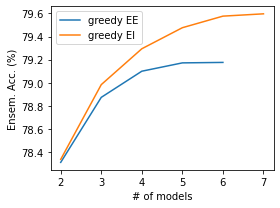

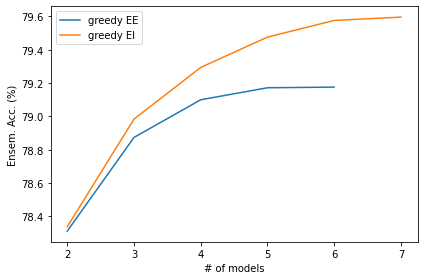

In [83]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(4,3))
x = np.arange(2,7)
plt.plot(x,np.array(greedy_E)*100,label='greedy EE')
x = np.arange(2,8)
plt.plot(x,np.array(greedy_EI)*100,label='greedy EI')
plt.legend()
plt.xticks(x)
plt.xlabel("# of models")
plt.ylabel("Ensem. Acc. (%)")
plt.legend()
plt.tight_layout()
plt.savefig("EvsEI_greedy.pdf")

import matplotlib.pyplot as plt
import numpy as np
plt.figure()
x = np.arange(2,7)
plt.plot(x,np.array(greedy_E)*100,label='greedy EE')
x = np.arange(2,8)
plt.plot(x,np.array(greedy_EI)*100,label='greedy EI')
plt.legend()
plt.xticks(x)
plt.xlabel("# of models")
plt.ylabel("Ensem. Acc. (%)")
plt.legend()
plt.tight_layout()
plt.savefig("EvsEI_greedy2.pdf")

In [ ]:
greedyEI = [eq69,inv31,eq54,eq31,inv,eq42, inv24]
greedyEE = [eq69,eq31,eq24,eq42,eq54,eq96]


In [191]:
# M = 2
# ds = 'v2'
for ds in ['v2', 'sketch']:
    for M in range(2,6):
        print(ds, "num_models ", M)
        num_classes=1000

        eq69 = torch.load(f"./logits_files/eq69_eval_on_{ds}.pth")
        eq42 = torch.load(f"./logits_files/eq42_eval_on_{ds}.pth")
        eq31 = torch.load(f"./logits_files/eq31_eval_on_{ds}.pth")
        eq24 = torch.load(f"./logits_files/eq24_eval_on_{ds}.pth")
        eq54 = torch.load(f"./logits_files/eq54_eval_on_{ds}.pth")
        eq96 = torch.load(f"./logits_files/eq96_eval_on_{ds}.pth")
        tar = torch.load(f"./logits_files/{ds}_targets.pth")

        inv = torch.load(f"./logits_files/inv_eval_on_{ds}.pth")
        inv31 = torch.load(f"./logits_files/inv31_eval_on_{ds}.pth")
        inv24 = torch.load(f"./logits_files/inv24_eval_on_{ds}.pth")
        inv69 = torch.load(f"./logits_files/inv69_eval_on_{ds}.pth")

        greedyEI = [eq69,inv31,eq54,eq31,inv,eq42, inv24]
        greedyEE = [eq69,eq31,eq24,eq42,eq54,eq96]

        sm_ei = [model.softmax(-1) for model in greedyEI[:M]]
        sm_ee = [model.softmax(-1) for model in greedyEE[:M]]

        out = torch.stack(sm_ei).mean(0)
        _,_,[ei_acc],_ =get_metrics([out],[tar],['EI'],printing=False)
        out = torch.stack(sm_ee).mean(0)
        _,_,[ee_acc],_ =get_metrics([out],[tar],['EE'],printing=False)
        print(f"EE: {ee_acc}, EI: {ei_acc}")


v2 num_models  2
EE: 0.6625999808311462, EI: 0.6589999794960022
v2 num_models  3
EE: 0.66839998960495, EI: 0.6685000061988831
v2 num_models  4
EE: 0.6726999878883362, EI: 0.6714000105857849
v2 num_models  5
EE: 0.6723999977111816, EI: 0.6715999841690063
sketch num_models  2
EE: 0.2582090497016907, EI: 0.24480733275413513
sketch num_models  3
EE: 0.2630823850631714, EI: 0.25838589668273926
sketch num_models  4
EE: 0.26490989327430725, EI: 0.2642024755477905
sketch num_models  5
EE: 0.26860421895980835, EI: 0.26418283581733704


In [192]:
for ds in ['adv', 'rend']:
    for M in range(2,6):
        print(ds, "num_models ", M)
        num_classes=200

        eq69 = torch.load(f"./logits_files/eq69_eval_on_{ds}.pth")
        eq42 = torch.load(f"./logits_files/eq42_eval_on_{ds}.pth")
        eq31 = torch.load(f"./logits_files/eq31_eval_on_{ds}.pth")
        eq24 = torch.load(f"./logits_files/eq24_eval_on_{ds}.pth")
        eq54 = torch.load(f"./logits_files/eq54_eval_on_{ds}.pth")
        eq96 = torch.load(f"./logits_files/eq96_eval_on_{ds}.pth")
        tar = torch.load(f"./logits_files/{ds}_targets.pth")

        inv = torch.load(f"./logits_files/inv_eval_on_{ds}.pth")
        inv31 = torch.load(f"./logits_files/inv31_eval_on_{ds}.pth")
        inv24 = torch.load(f"./logits_files/inv24_eval_on_{ds}.pth")
        inv69 = torch.load(f"./logits_files/inv69_eval_on_{ds}.pth")

        greedyEI = [eq69,inv31,eq54,eq31,inv,eq42, inv24]
        greedyEE = [eq69,eq31,eq24,eq42,eq54,eq96]

        sm_ei = [model.softmax(-1) for model in greedyEI[:M]]
        sm_ee = [model.softmax(-1) for model in greedyEE[:M]]

        out = torch.stack(sm_ei).mean(0)
        _,_,[ei_acc],_ =get_metrics([out],[tar],['EI'],printing=False,num_classes=num_classes)
        out = torch.stack(sm_ee).mean(0)
        _,_,[ee_acc],_ =get_metrics([out],[tar],['EE'],printing=False,num_classes=num_classes)
        print(f"EE: {ee_acc}, EI: {ei_acc}")

adv num_models  2
EE: 0.07079999893903732, EI: 0.06986666470766068
adv num_models  3
EE: 0.06920000165700912, EI: 0.06639999896287918
adv num_models  4
EE: 0.07013333588838577, EI: 0.06719999760389328
adv num_models  5
EE: 0.06906666606664658, EI: 0.06759999692440033
rend num_models  2
EE: 0.3796333372592926, EI: 0.3677000105381012
rend num_models  3
EE: 0.38483333587646484, EI: 0.3797999918460846
rend num_models  4
EE: 0.38856667280197144, EI: 0.3864000141620636
rend num_models  5
EE: 0.38993334770202637, EI: 0.3842333257198334
